In [1]:
import numpy as np
import nibabel as nib
%matplotlib inline
import matplotlib.pyplot as plt
import albumentations as ab
from scipy.ndimage.filters import gaussian_filter, sobel
import skimage.transform as skTrans

In [2]:
def load_image(file_path):
    img = nib.load(file_path)
    return img.get_data()

def show_image(image, mask, index=0):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))
    #ax1.imshow(image[:, :, index], cmap='gray', vmin=0.0, vmax=1.0)
    ax1.imshow(image[:, :, index])
    ax1.set_title('')
    #ax2.imshow(mask[:, :, 7], cmap='gray', vmin=0.0, vmax=1.0)
    ax2.imshow(mask[:, :, index])
    ax2.set_title('')

def do_crop_3d(image, x, y, z, h, w, d):

    return image[x:x + h, y:y + w, z:z + d, :]

def adjust_brightness(image, delta=0.125):

    return image + delta

def adjust_contrast(image, contrast_factor = 1.5):
    image_mean = np.mean(image)

    return (contrast_factor * (image - image_mean)) + image_mean

def rotate_image(image, rot):

    rotated_image = []

    if rot == 1:
        rotated_image = np.transpose(np.flip(image, 1), (1, 0, 2, 3))  # 90 deg Z
    elif rot == 2:
        rotated_image = np.flip(np.transpose(image, (1, 0, 2, 3)), 1)  # -90 deg Z
    elif rot == 3:
        rotated_image = np.flip(image, (0, 1))  # 180 degrees on z axis
    elif rot == 4:
        rotated_image = np.transpose(image, (0, 2, 1, 3))  # 90 deg X
    elif rot == 5:
        rotated_image = np.flip(np.transpose(image, (0, 2, 1, 3)), 1)  # -90 deg X
    elif rot == 6:
        rotated_image = np.flip(image, (1, 2))  # 180 degrees on x axis
    elif rot == 7:
        rotated_image = np.transpose(np.flip(image, 0), (2, 1, 0, 3))  # 90 deg Y
    elif rot == 8:
        rotated_image = np.transpose(np.flip(image, 0), (2, 1, 0, 3))  # -90 deg Y
    elif rot == 9:
        rotated_image = np.flip(image, (0, 2))  # 180 degrees on y axis

    return rotated_image


def resize(image, new_size):
    # image.shape[3] is the number of channels
    new_image = np.zeros((new_size, new_size, new_size, image.shape[3]))

    for z in range(image.shape[2]):
            new_image[:, :, z, :] = np.array(ab.Resize(new_size, new_size)(image=image[:,:,z])["image"])
    return new_image

def crop_and_resize(image, alpha=4):

    # All sides have the same size so anyone would do
    max_crop_length = int(image.shape[0] / alpha)
    max_start = (image.shape[0] - max_crop_length) - 2 # To make sure no IndexOutOfBound occurs

    # Select the starting point of the cropping randomly
    start_x = np.random.randint(0, max_start)
    start_y = np.random.randint(0, max_start)
    start_z = np.random.randint(0, max_start)

    # Cropp a cubic image, if another form of cropping is required then we need to pass different 
    # values instead of the same max_crop_length for all
    cropped_image = do_crop_3d(image, start_x, start_y, start_z, max_crop_length, max_crop_length, max_crop_length)
    
    return resize(cropped_image, image.shape[0])
    #return skTrans.resize(cropped_image, image.shape, order=1, preserve_range=True)

def add_gaussian_noise(image, max_mean=0.3, max_sigma=0.1):
    mean = np.random.uniform(-max_mean, max_mean)
    sigma = np.random.uniform(0.0, max_sigma)
    
    gauss = np.random.normal(mean, sigma,image.shape)
    
    return image + gauss

def apply_gaussian_filter(image, max_sigma=1.0):
    sigma = np.random.uniform(0.0, max_sigma)
    
    return gaussian_filter(image, sigma)

def apply_sobel_filter(image):
    dx = sobel(image, 0)
    dy = sobel(image, 1)
    dz = sobel(image, 2)
    
    mag = np.sqrt(dx**2 + dy**2 + dz**2)
    filtered  = mag * (1.0 / np.max(mag))
    
    return filtered

def cut_out(image, alpha=4):

    # All sides have the same size so anyone would do
    max_cutout_length = int(image.shape[0] / alpha)
    max_start = (image.shape[0] - max_cutout_length) - 2 # To make sure no IndexOutOfBound occurs

    # Select the starting point of the cropping randomly
    start_x = np.random.randint(0, max_start)
    end_x = start_x +  max_cutout_length
    
    start_y = np.random.randint(0, max_start)
    end_y = start_y + max_cutout_length
    
    start_z = np.random.randint(0, max_start)
    end_z = start_z +  max_cutout_length
    
    cutout_pixels = np.zeros((end_x - start_x, end_y - start_y, end_z - start_z,1))
    
    cutout_image = image.copy()
    cutout_image[start_x:end_x, start_y:end_y, start_z:end_z, :] =  cutout_pixels
    
    return cutout_image
    


/usr/local/Caskroom/miniconda/base/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until


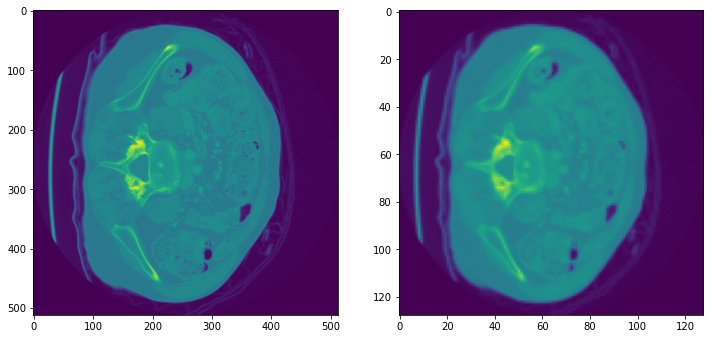

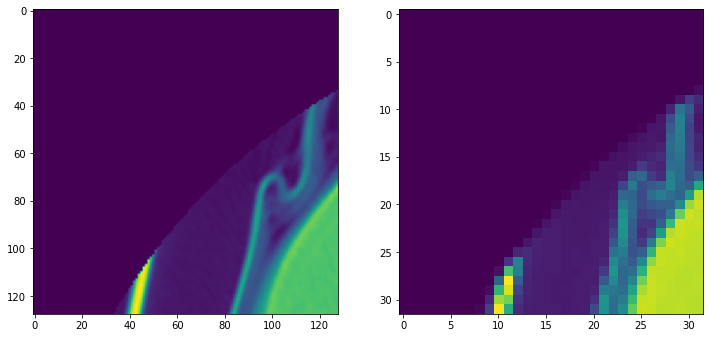

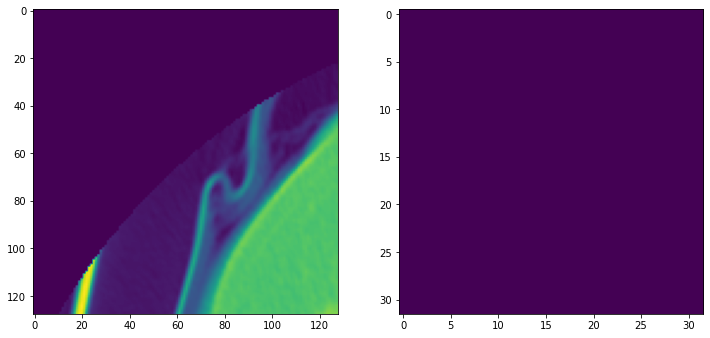

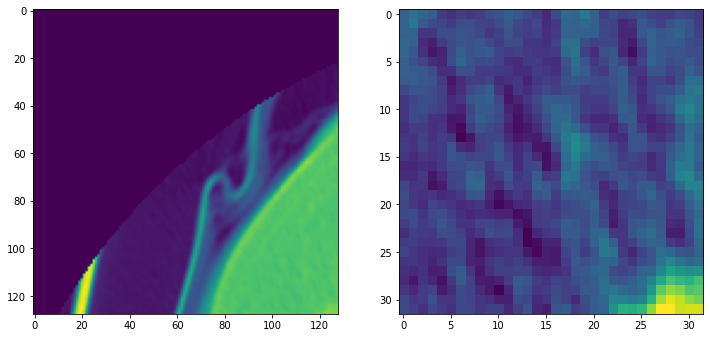

In [16]:
original_image = load_image("/Users/d070867/netstore/workspace/cpc_pancreas3d/Task07_Pancreas/Task07_Pancreas/pancreas_035.nii")
resized_original = skTrans.resize(original_image, (128,128,128), order=1, preserve_range=True)

show_image(original_image, resized_original, 0)

show_image(original_image[:128,:128,:], resized_original[:32,:32,:], 0)


image_128_1 = np.load(f"/Users/d070867/netstore/workspace/cpc_pancreas3d/Task07_Pancreas/Task07_Pancreas/result/train/pancreas_035_0.npy")
show_image(image_128_1, image_128_1[0:32,0:32,:], 0)
show_image(image_128_1, image_128_1[96:128,96:128,:], 0)





(64, 64, 50, 1)
(64, 64, 50, 1)
(64, 64, 50, 1)
(64, 64, 50, 1)
(64, 64, 50, 1)
(64, 64, 50, 1)
(64, 64, 50, 1)
(64, 64, 50, 1)
(64, 64, 50, 1)
(64, 64, 50, 1)
(64, 64, 50, 1)
(64, 64, 50, 1)


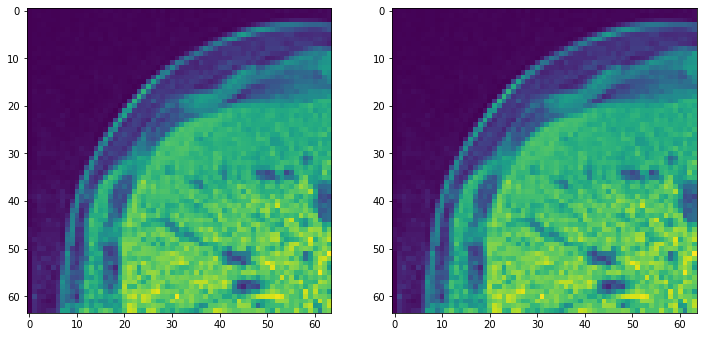

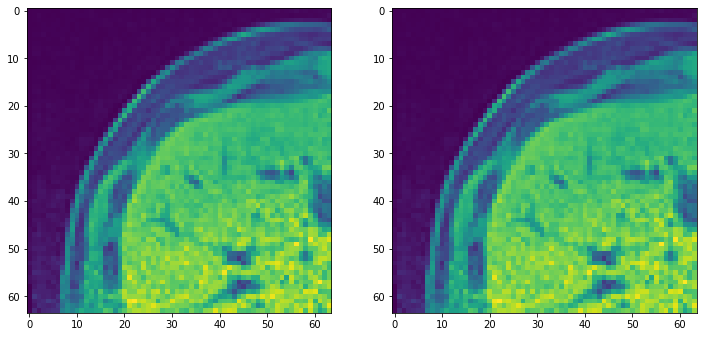

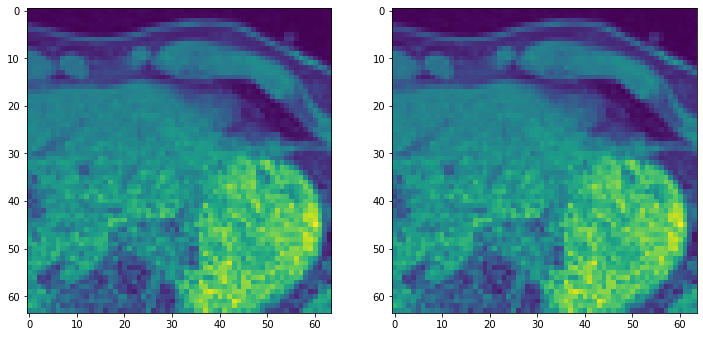

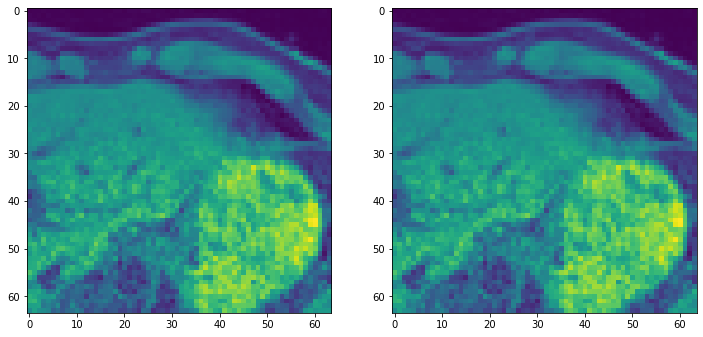

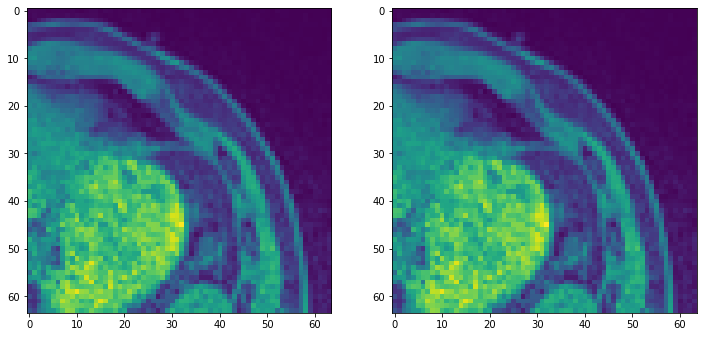

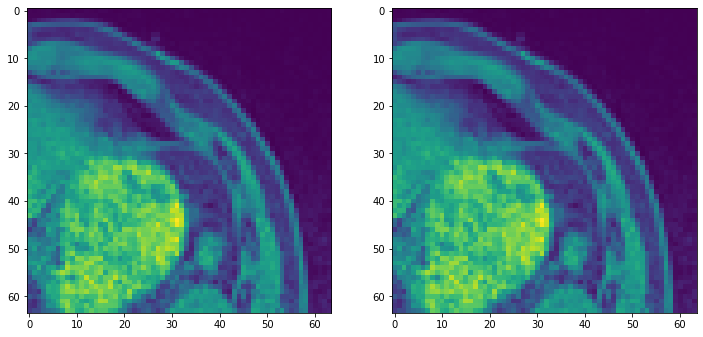

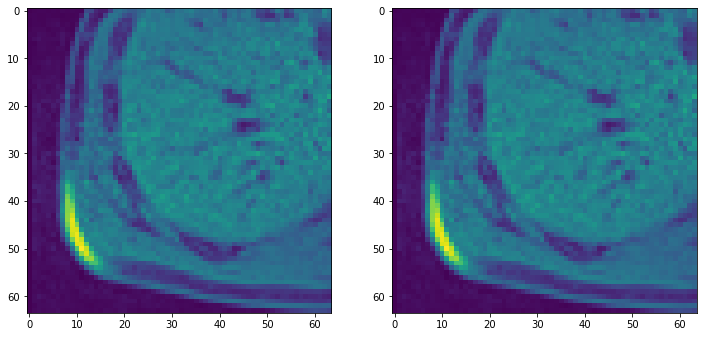

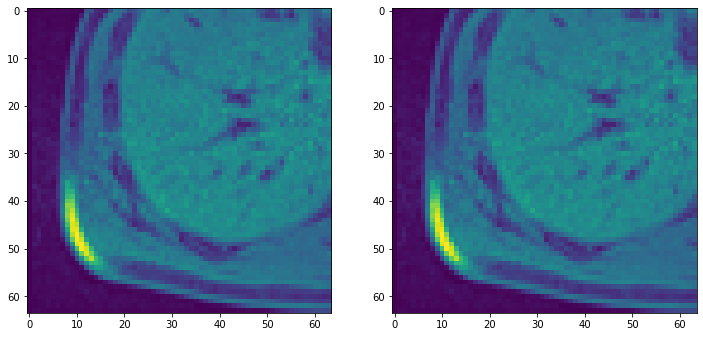

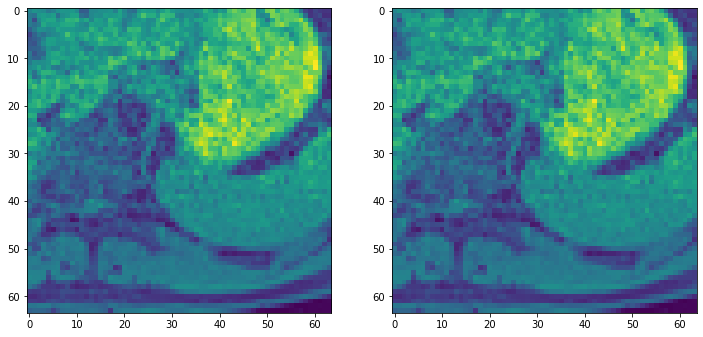

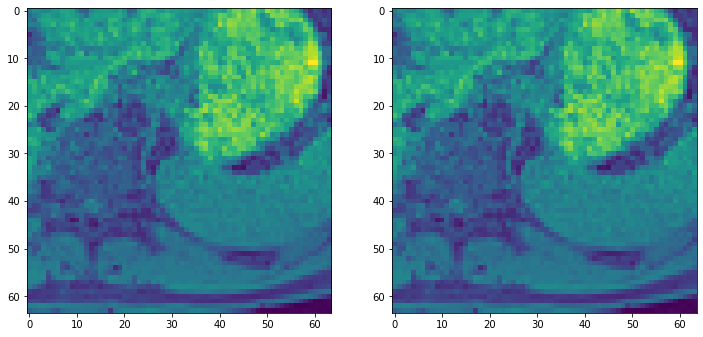

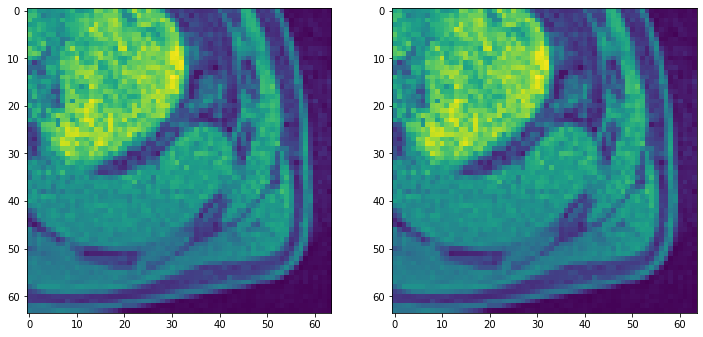

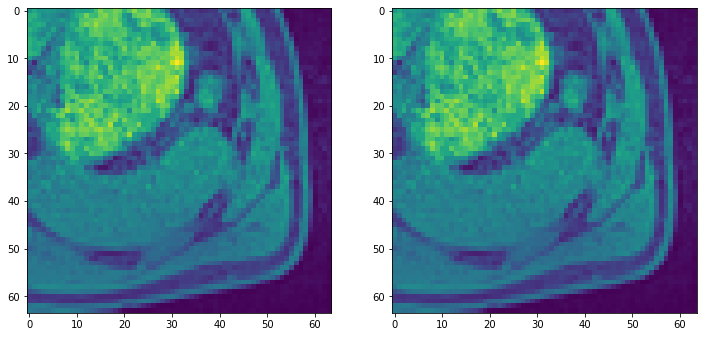

In [17]:
for i in range(12):
    image = np.load(f"/Users/d070867/netstore/workspace/ukbio/processed/eg_pan_fat_1_{i}.npy")
    show_image(image, image, 0)
    print(image.shape)
